## Stereo camera calibration

Import necessary libraries.

In [1]:
import numpy as np
import cv2

import glob
import matplotlib.pyplot as plt

Define calibration parameters and image paths.

In [2]:
# Chessboard dimensions (number of inner corners)
chessboard_size = (10, 7) # Adjust based on your chessboard
square_size = 35 # Define the real-world size of a square (e.g., in cm or mm). This is important for accurate 3D reconstruction but not strictly necessary for disparity alone.

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Paths to calibration images
left_calib_path = 'photos/left/calibration/*.jpg' # Adjust pattern if needed
right_calib_path = 'photos/right/calibration/*.jpg' # Adjust pattern if needed

# Paths to test images
left_test_path = 'photos/left/test/20250502_193303.jpg' # Adjust filename
right_test_path = 'photos/right/test/20250502_193303.jpg' # Adjust filename

Prepare object points (3D points in real world space).

In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp = objp * square_size # Scale by square size if needed for metric reconstruction

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane for left camera
imgpoints_right = [] # 2d points in image plane for right camera

img_shape = None # To store image shape

### Calibrate Left Camera

In [4]:
images_left = sorted(glob.glob(left_calib_path))

print(f"Found {len(images_left)} left calibration images.")

for fname in images_left:
    img = cv2.imread(fname)
    if img is None:
        print(f"Warning: Could not read image {fname}")
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img_shape is None:
        img_shape = gray.shape[::-1] # Get (width, height)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_left.append(corners2)

        # Draw and display the corners (optional)
        # cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)
    else:
         print(f"Warning: Chessboard not found in {fname}")

# cv2.destroyAllWindows()

if not imgpoints_left:
    print("Error: No valid calibration images found for the left camera.")
else:
    print(f"Using {len(imgpoints_left)} images for left camera calibration.")
    ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints[:len(imgpoints_left)], imgpoints_left, img_shape, None, None)
    print("Left Camera Matrix:\n", mtx_left)
    print("Left Distortion Coefficients:\n", dist_left)

Found 45 left calibration images.
Using 45 images for left camera calibration.
Left Camera Matrix:
 [[1.26711172e+03 0.00000000e+00 1.03160300e+03]
 [0.00000000e+00 1.26304728e+03 5.80682343e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Left Distortion Coefficients:
 [[-3.18768515e-01  1.53727514e-01 -2.80679759e-04 -2.08611901e-03
  -2.50193347e-02]]


### Calibrate Right Camera

In [5]:
images_right = sorted(glob.glob(right_calib_path))
objpoints_calib_right = [] # Use only points from images where corners were found for this camera

print(f"Found {len(images_right)} right calibration images.")

for fname in images_right:
    img = cv2.imread(fname)
    if img is None:
        print(f"Warning: Could not read image {fname}")
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img_shape is None: # Should be set by left camera, but check just in case
        img_shape = gray.shape[::-1]

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints_calib_right.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_right.append(corners2)
    else:
         print(f"Warning: Chessboard not found in {fname}")

if not imgpoints_right:
    print("Error: No valid calibration images found for the right camera.")
elif len(imgpoints_left) != len(imgpoints_right):
    print("Error: Number of valid calibration images for left and right cameras do not match. Stereo calibration requires corresponding pairs.")
    # Consider adding logic here to find matching pairs if needed
else:
    print(f"Using {len(imgpoints_right)} images for right camera calibration.")
    ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints_calib_right, imgpoints_right, img_shape, None, None)
    print("Right Camera Matrix:\n", mtx_right)
    print("Right Distortion Coefficients:\n", dist_right)

Found 45 right calibration images.
Using 45 images for right camera calibration.
Right Camera Matrix:
 [[1.22511578e+03 0.00000000e+00 9.78321757e+02]
 [0.00000000e+00 1.22338839e+03 5.79961875e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Right Distortion Coefficients:
 [[-0.30451902  0.14876224  0.00037916 -0.00124677 -0.02553734]]


### Stereo Calibration

Perform stereo calibration using the results from individual camera calibrations.

In [6]:
mtx_right = mtx_left
dist_right = dist_left

if len(imgpoints_left) == len(imgpoints_right) and len(imgpoints_left) > 0:
    # Ensure we use the same object points that correspond to the valid image points for both cameras
    # Assuming objpoints, imgpoints_left, imgpoints_right were populated correctly in sync
    valid_objpoints = objpoints[:len(imgpoints_left)] # Or implement pair matching logic

    flags = 0
    # flags |= cv2.CALIB_FIX_INTRINSIC # Fix intrinsics if already calibrated accurately
    flags |= cv2.CALIB_USE_INTRINSIC_GUESS
    flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
    flags |= cv2.CALIB_RATIONAL_MODEL
    # Add other flags as needed, e.g., CALIB_SAME_FOCAL_LENGTH

    stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

    ret_stereo, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
        valid_objpoints, imgpoints_left, imgpoints_right,
        mtx_left, dist_left, mtx_right, dist_right, img_shape,
        criteria=stereocalib_criteria, flags=flags
    )

    if ret_stereo:
        print("Stereo calibration successful.")
        print("Rotation Matrix (R):\n", R)
        print("Translation Vector (T):\n", T)
        # Update camera matrices and distortion coefficients with refined values
        mtx_left = M1
        dist_left = d1
        mtx_right = M2
        dist_right = d2
    else:
        print("Stereo calibration failed.")
else:
    print("Skipping stereo calibration due to previous errors or mismatch in image pairs.")

Stereo calibration successful.
Rotation Matrix (R):
 [[ 9.99617802e-01 -9.82558004e-04 -2.76276176e-02]
 [ 2.09933561e-03  9.99180467e-01  4.04226126e-02]
 [ 2.75652583e-02 -4.04651628e-02  9.98800644e-01]]
Translation Vector (T):
 [[166.14440447]
 [  0.478829  ]
 [  7.59410713]]


### Stereo Rectification

Compute rectification transforms and undistortion maps.

In [8]:
if 'R' in locals() and 'T' in locals(): # Check if stereo calibration was successful
    # Compute rectification transforms
    R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(
        mtx_left, dist_left, mtx_right, dist_right, img_shape, R, T,
        flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9 # alpha=0 crops less, alpha=1 crops more
    )

    print("Rectification Projection Matrix Left (P1):\n", P1)
    print("Rectification Projection Matrix Right (P2):\n", P2)
    print("Disparity-to-depth mapping matrix (Q):\n", Q)

    # Save P1, P2, and Q to files
    np.save('P1.npy', P1)
    np.save('P2.npy', P2)
    np.save('Q.npy', Q)
    print("P1, P2, and Q saved to P1.npy, P2.npy, and Q.npy")

    # Compute undistortion and rectification maps
    map1_left, map2_left = cv2.initUndistortRectifyMap(mtx_left, dist_left, R1, P1, img_shape, cv2.CV_16SC2)
    map1_right, map2_right = cv2.initUndistortRectifyMap(mtx_right, dist_right, R2, P2, img_shape, cv2.CV_16SC2)
    print("Rectification maps computed.")
else:
    print("Skipping rectification map computation due to stereo calibration failure.")
    

Rectification Projection Matrix Left (P1):
 [[976.0551334    0.         975.76013184   0.        ]
 [  0.         976.0551334  589.78937531   0.        ]
 [  0.           0.           1.           0.        ]]
Rectification Projection Matrix Right (P2):
 [[9.76055133e+02 0.00000000e+00 9.75760132e+02 1.62336083e+05]
 [0.00000000e+00 9.76055133e+02 5.89789375e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Disparity-to-depth mapping matrix (Q):
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -9.75760132e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.89789375e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.76055133e+02]
 [ 0.00000000e+00  0.00000000e+00 -6.01255813e-03  0.00000000e+00]]
P1, P2, and Q saved to P1.npy, P2.npy, and Q.npy
Rectification maps computed.


In [11]:
np.savez("remap_data.npz",
        map1_left=map1_left,
        map1_right=map1_right,
        map2_left=map2_left,
        map2_right=map2_right)

### Load and Rectify Test Images

Test images loaded and rectified.


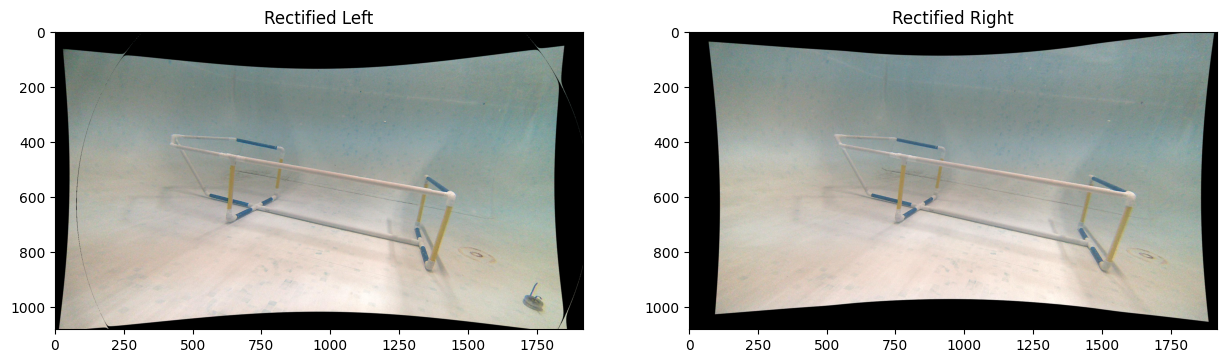

In [8]:
img_left_test = cv2.imread(left_test_path)
img_right_test = cv2.imread(right_test_path)

if img_left_test is None or img_right_test is None:
    print("Error: Could not load test images.")
elif 'map1_left' not in locals(): # Check if maps were computed
    print("Error: Rectification maps not available. Cannot rectify test images.")
else:
    # Rectify images
    img_left_rect = cv2.remap(img_left_test, map1_left, map2_left, cv2.INTER_LINEAR)
    img_right_rect = cv2.remap(img_right_test, map1_right, map2_right, cv2.INTER_LINEAR)

    # Crop images based on ROI (optional, helps remove invalid areas)
    # x, y, w, h = roi_left
    # img_left_rect = img_left_rect[y:y+h, x:x+w]
    # x, y, w, h = roi_right
    # img_right_rect = img_right_rect[y:y+h, x:x+w]

    print("Test images loaded and rectified.")

    # Display rectified images
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(cv2.cvtColor(img_left_rect, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Rectified Left')
    axes[1].imshow(cv2.cvtColor(img_right_rect, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Rectified Right')
    plt.show()

### Why Grayscale for Disparity Computation?

The `cv2.StereoBM` and `cv2.StereoSGBM` algorithms in OpenCV are designed to work with single-channel (grayscale) images. Here's why:

1.  **Algorithm Design:** Traditional stereo matching algorithms like Block Matching (BM) and Semi-Global Block Matching (SGBM) rely on comparing the intensity values of pixel patches (blocks) between the left and right images to find correspondences. Grayscale provides this intensity information directly.
2.  **Computational Efficiency:** Processing one channel is significantly faster and requires less memory than processing three channels (RGB).
3.  **Focus on Geometry:** These algorithms primarily use texture and intensity gradients to find matching points, which define the geometry. While color can sometimes help, it can also introduce ambiguity or be sensitive to lighting variations between the two cameras. Grayscale intensity is often a more robust feature for these specific methods.

Therefore, you cannot directly pass RGB images to `stereo.compute()`. The standard approach is to convert the rectified images to grayscale before computing the disparity map. Preprocessing steps (like CLAHE or color balancing) are applied *before* or *during* the conversion to grayscale to enhance the relevant features for the matching algorithm.

### Compute Disparity Map

Original size: (1080, 1920), Downsampled size: (1080, 1920)


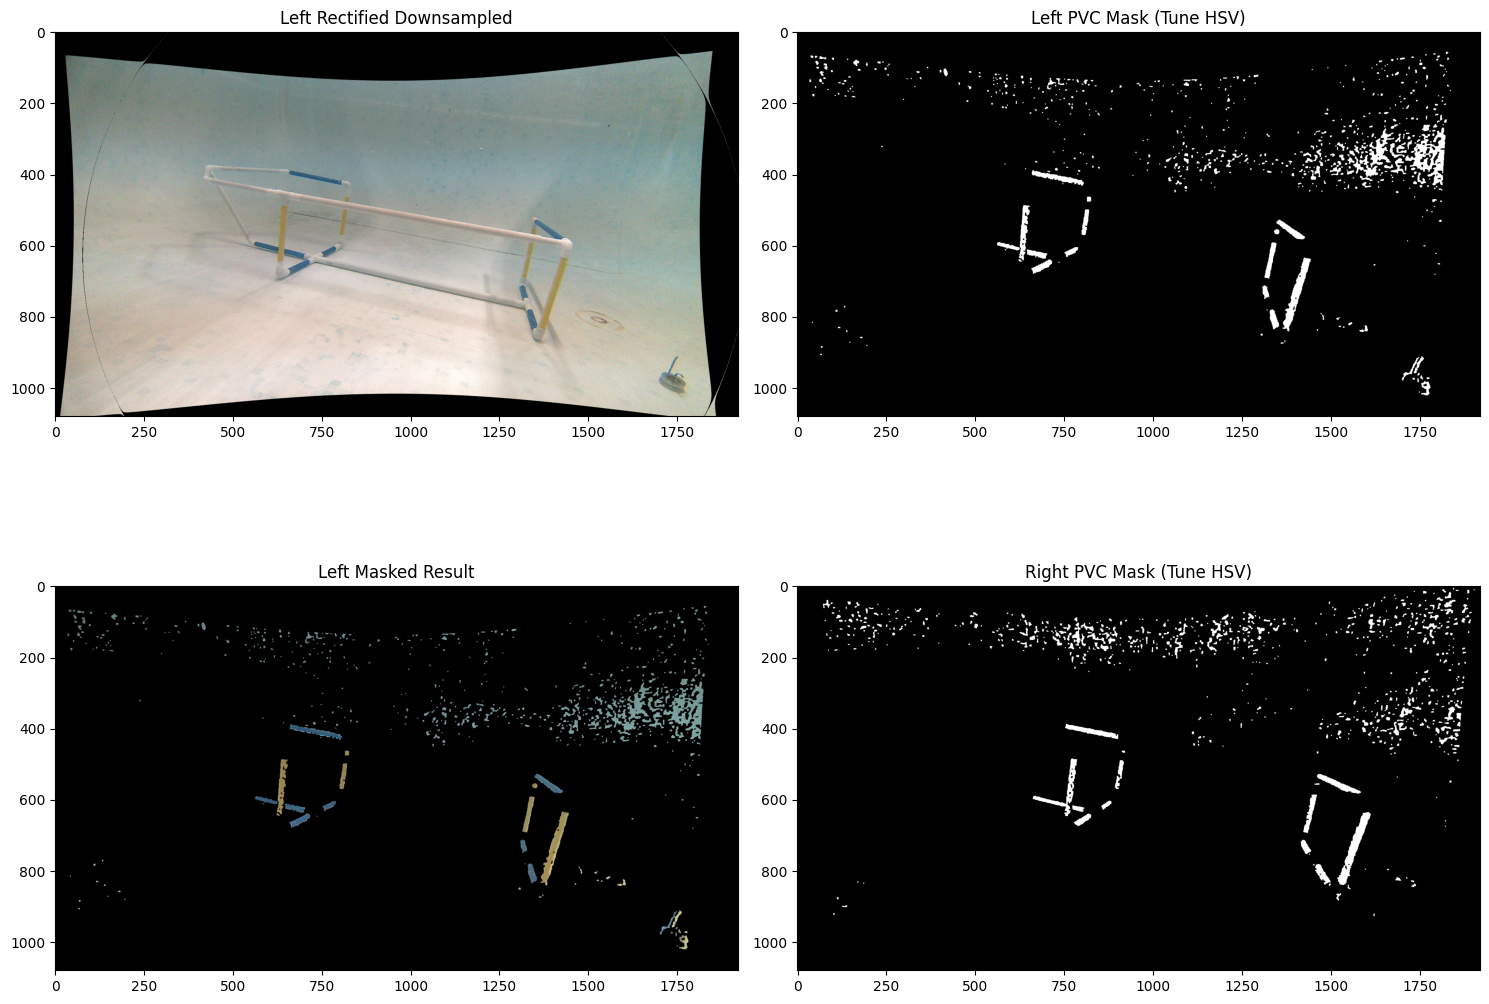

Applied CLAHE to grayscale images.


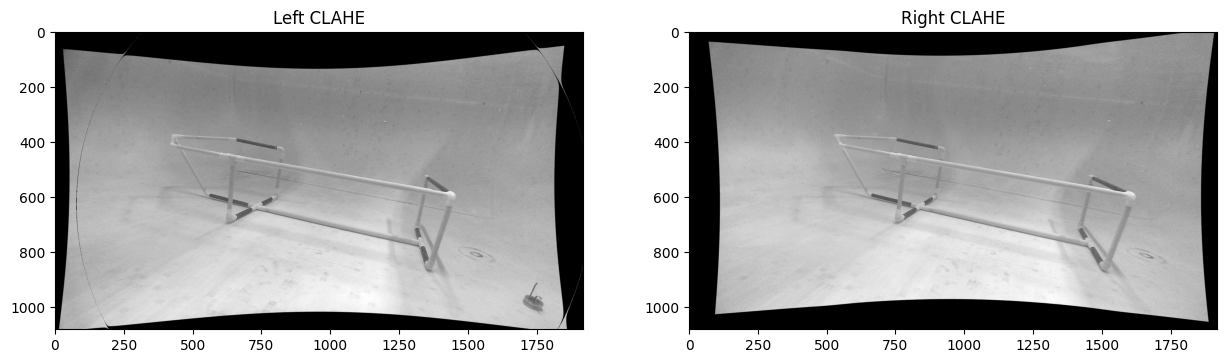

In [9]:
if 'img_left_rect' in locals(): # Check if rectified images exist
    # --- Downsample the rectified images (e.g., by half) ---
    # img_left_rect_down = cv2.pyrDown(img_left_rect)
    # img_right_rect_down = cv2.pyrDown(img_right_rect)
    img_left_rect_down = img_left_rect
    img_right_rect_down = img_right_rect
    
    # img_left_rect_down = cv2.pyrDown(img_left_rect_down)
    # img_right_rect_down = cv2.pyrDown(img_right_rect_down)
    print(f"Original size: {img_left_rect.shape[:2]}, Downsampled size: {img_left_rect_down.shape[:2]}")

    # --- Color Segmentation for PVC Tubes (using HSV) ---
    hsv_left = cv2.cvtColor(img_left_rect_down, cv2.COLOR_BGR2HSV)
    hsv_right = cv2.cvtColor(img_right_rect_down, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for light blue/cyan/whiteish colors (NEEDS TUNING)
    # Hue range for blue/cyan is roughly 80-130
    # Saturation: Can be low if washed out, or higher. Start broad.
    # Value: Should be relatively high (bright). Start broad.
    lower_pvc = np.array([20, 50, 100])  # Lower HSV bound (TUNE THESE VALUES)
    upper_pvc = np.array([130, 255, 255]) # Upper HSV bound (TUNE THESE VALUES)
    
    # Create masks
    mask_left = cv2.inRange(hsv_left, lower_pvc, upper_pvc)
    mask_right = cv2.inRange(hsv_right, lower_pvc, upper_pvc)
    
    # Optional: Apply morphological operations (opening/closing) to clean up the mask
    kernel = np.ones((3,3),np.uint8)
    mask_left = cv2.morphologyEx(mask_left, cv2.MORPH_OPEN, kernel)
    mask_right = cv2.morphologyEx(mask_right, cv2.MORPH_OPEN, kernel)
    mask_left = cv2.morphologyEx(mask_left, cv2.MORPH_CLOSE, kernel)
    mask_right = cv2.morphologyEx(mask_right, cv2.MORPH_CLOSE, kernel)
    
    # Visualize the mask (important for tuning)
    res_left = cv2.bitwise_and(img_left_rect_down, img_left_rect_down, mask=mask_left)
    res_right = cv2.bitwise_and(img_right_rect_down, img_right_rect_down, mask=mask_right)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0, 0].imshow(cv2.cvtColor(img_left_rect_down, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Left Rectified Downsampled')
    axes[0, 1].imshow(mask_left, cmap='gray')
    axes[0, 1].set_title('Left PVC Mask (Tune HSV)')
    axes[1, 0].imshow(cv2.cvtColor(res_left, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('Left Masked Result')
    axes[1, 1].imshow(mask_right, cmap='gray')
    axes[1, 1].set_title('Right PVC Mask (Tune HSV)')
    plt.tight_layout()
    plt.show()
    
    # Convert downsampled rectified images to grayscale
    gray_left_rect = cv2.cvtColor(img_left_rect_down, cv2.COLOR_BGR2GRAY)
    gray_right_rect = cv2.cvtColor(img_right_rect_down, cv2.COLOR_BGR2GRAY)
    
    # --- Preprocessing: Apply CLAHE for contrast enhancement ---
    # Consider applying CLAHE only within the mask, or differently outside vs inside.
    # For now, apply globally to see the effect.
    clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(20,20))
    gray_left_clahe = clahe.apply(gray_left_rect)
    gray_right_clahe = clahe.apply(gray_right_rect)
    # gray_left_clahe = gray_left_rect
    # gray_right_clahe = gray_right_rect
    print("Applied CLAHE to grayscale images.")
    
    # Optional: Display CLAHE images to check effect
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(gray_left_clahe, cmap='gray')
    axes[0].set_title('Left CLAHE')
    axes[1].imshow(gray_right_clahe, cmap='gray')
    axes[1].set_title('Right CLAHE')
    plt.show()
else:
    print("Skipping disparity computation as rectified images are not available.")

In [10]:
if 'img_left_rect' in locals(): # Check if rectified images exist

    # --- StereoBM Matcher ---
    # Adjust parameters for better results, especially after CLAHE
    numDisparities = 16 * 15 # Must be divisible by 16. Tune this.
    blockSize = 7        # Must be odd. Tune this.
    stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)
    stereo.setUniquenessRatio(10)
    stereo.setSpeckleWindowSize(20) # Tune these post-processing steps
    stereo.setSpeckleRange(4)
    stereo.setDisp12MaxDiff(1)
    # stereo.setMinDisparity(0) # Default is 0

    # --- Stereo SGBM Matcher (Commented out) ---
    # ... existing SGBM code ...
    # )

    # Compute disparity map using CLAHE-enhanced images
    print(f"Computing disparity with numDisparities={numDisparities}, blockSize={blockSize} using StereoBM on CLAHE images...")
    disparity_bm = stereo.compute(gray_left_clahe, gray_right_clahe)
    
    # Convert disparity to float (StereoBM output is CV_16S, not divided by 16)
    disparity = disparity_bm.astype(np.float32)
    # Disparity values from BM are not scaled by 16, so we don't divide here.
    # We might need to handle negative disparities if minDisparity is non-zero, but default is 0.
    print("Disparity map computed.")

    # Normalize the disparity map for visualization
    # Filter out invalid disparities (often -1 or other specific values for BM)
    # StereoBM typically outputs disparities scaled by 16, but stored as int16.
    # Invalid disparities are usually represented by (min_disparity - 1) * 16.
    # Since min_disparity is 0 by default, invalid is -16.
    valid_mask = disparity > -16 # Filter out invalid disparities
    valid_disparity = disparity.copy()
    valid_disparity[~valid_mask] = 0 # Set invalid disparities to 0 for normalization
    
    # Normalize only the valid range
    if np.any(valid_mask): # Avoid division by zero if all disparities are invalid
       disparity_visual = cv2.normalize(valid_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U, mask=valid_mask.astype(np.uint8))
    else:
       disparity_visual = np.zeros_like(disparity, dtype=np.uint8)

else:
    print("Skipping disparity computation as rectified images are not available.")

Computing disparity with numDisparities=240, blockSize=7 using StereoBM on CLAHE images...
Disparity map computed.
Disparity map computed.


### Visualize Disparity Map

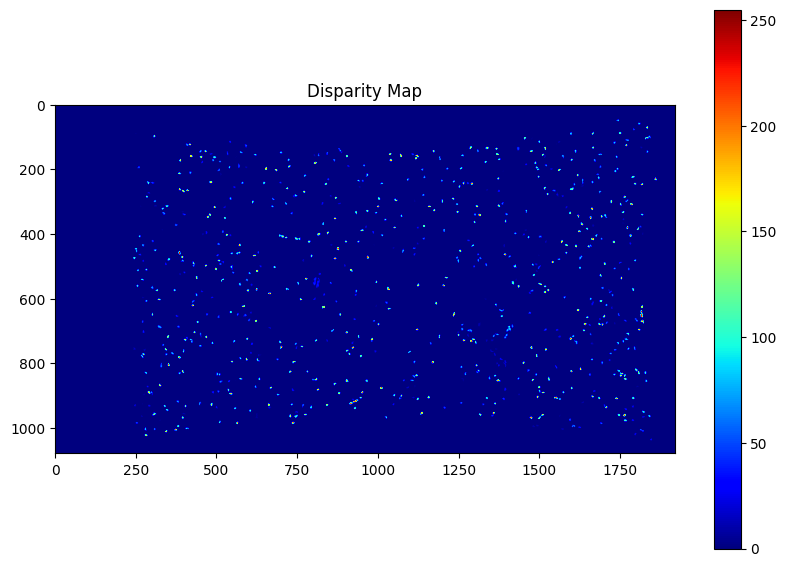

In [11]:
if 'disparity_visual' in locals():
    plt.figure(figsize=(10, 7))
    plt.imshow(disparity_visual, cmap='jet') # 'viridis' or 'plasma' are also good colormaps
    plt.colorbar()
    plt.title('Disparity Map')
    plt.show()
    
    # Optionally save the disparity map
    # cv2.imwrite('disparity_map.png', disparity_visual)
else:
    print("Disparity map not available for visualization.")

In [12]:
selected_points_left = [(214*2, 189*2), (692*2, 277*2)]
window_name = 'Select 2 Points - Left Image (Press any key to finish)'

# Mouse callback function
def select_point_callback(event, x, y, flags, param):
    global selected_points_left, img_display_copy # Use global to modify
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(selected_points_left) < 2:
            selected_points_left.append((x, y))
            print(f"Point {len(selected_points_left)} selected: ({x}, {y})")
            # Draw feedback on the image copy
            cv2.circle(img_display_copy, (x, y), 5, (0, 0, 255) if len(selected_points_left) == 1 else (255, 0, 0), -1)
            cv2.imshow(window_name, img_display_copy)
        else:
            print("Already selected 2 points. Press any key to finish.")

if 'img_left_rect_down' in locals() and len(selected_points_left) < 2:
    img_display_copy = img_left_rect_down.copy() # Work on a copy to draw on
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, select_point_callback)
    
    print("Please click on two points in the '{}' window.".format(window_name))
    print("Press any key in the window when done.")
    
    cv2.imshow(window_name, img_display_copy)
    cv2.waitKey(0) # Wait indefinitely for a key press
    cv2.destroyAllWindows()
    
    if len(selected_points_left) == 2:
        print(f"\nFinal selected points (x, y): {selected_points_left}")
    else:
        print("\nWarning: Two points were not selected. Proceeding with {} points.".format(len(selected_points_left)))
        # Keep selected_points_left as is, the next cell will handle the length check
else:
    print("Downsampled left rectified image ('img_left_rect_down') not found.")

Downsampled left rectified image ('img_left_rect_down') not found.


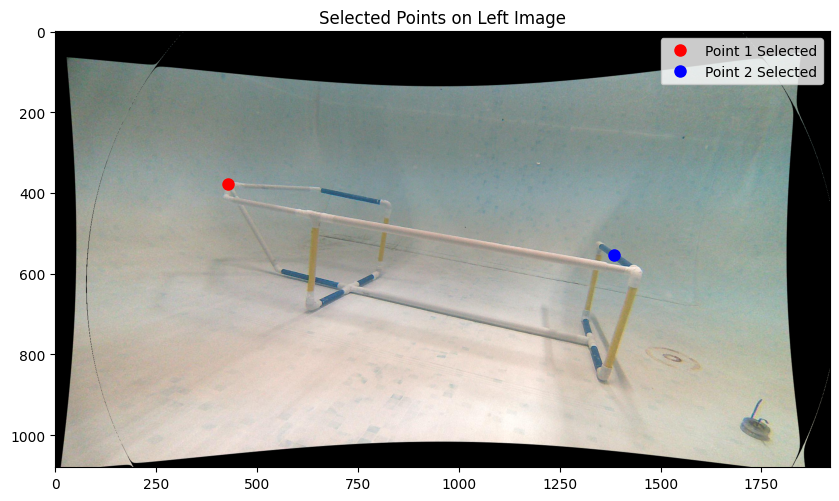

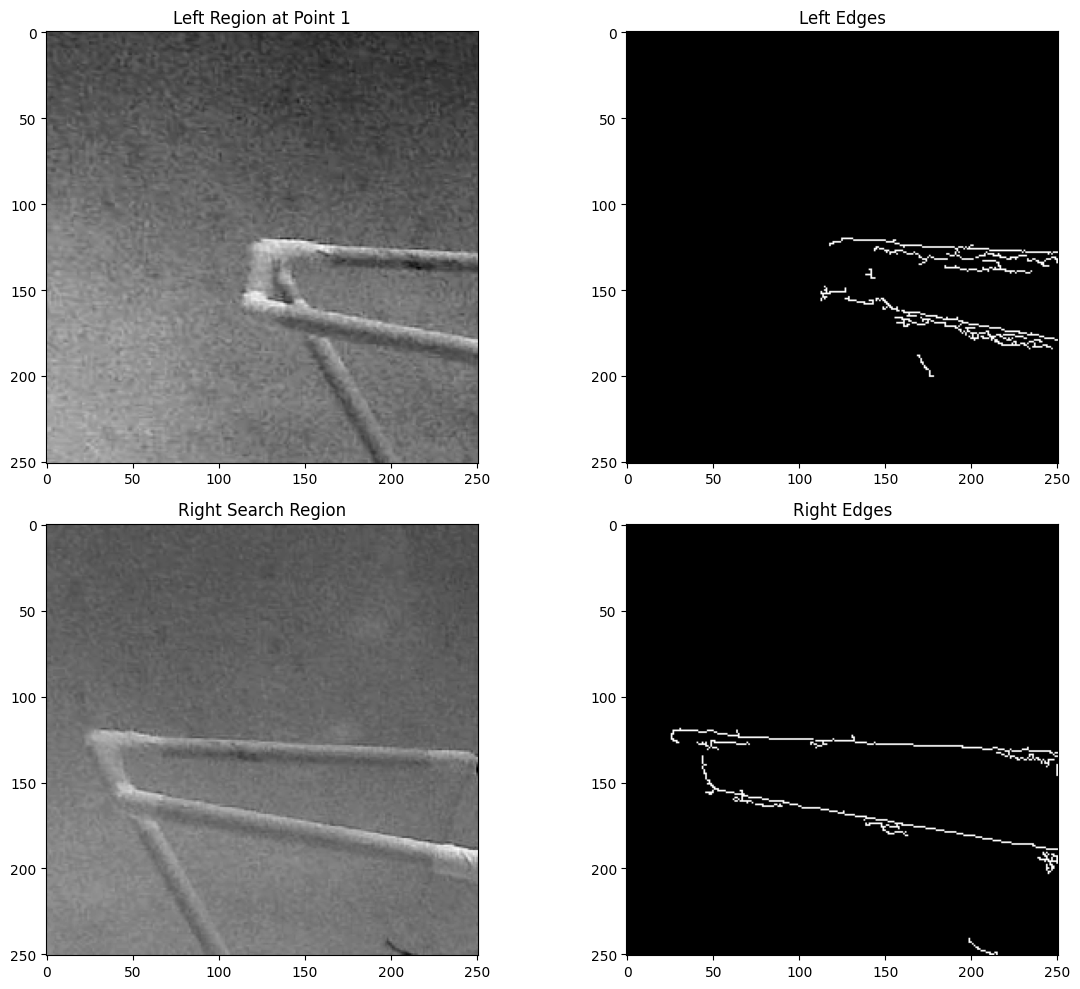

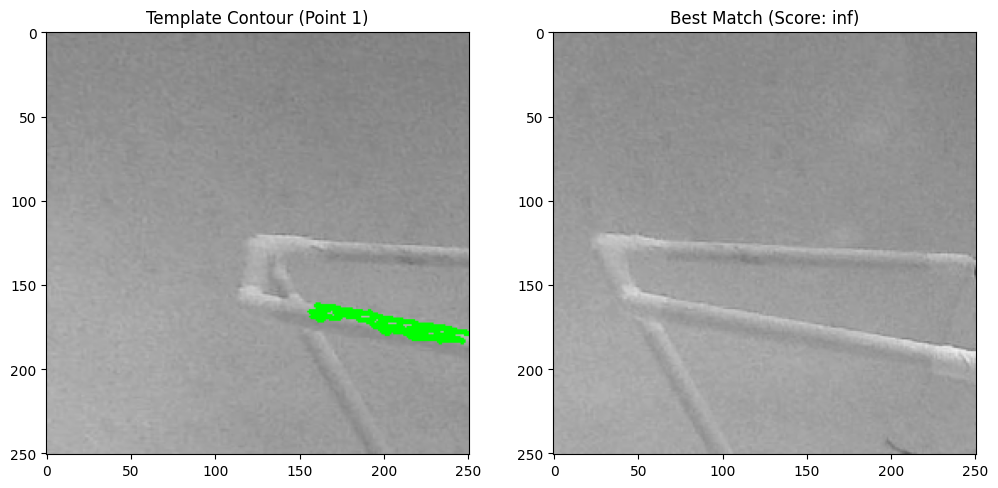

No suitable contour match found for point 1


In [13]:
if (len(selected_points_left) == 2 and 
    'gray_left_clahe' in locals() and 
    'gray_right_clahe' in locals() and 
    'img_left_rect_down' in locals() and  # Add check for left image
    'img_right_rect_down' in locals() and # Add check for right image
    'P1' in locals() and 
    'P2' in locals()): # Removed numDisparities check here, will define below
    
    points_left_down = [(int(round(p[0])), int(round(p[1]))) for p in selected_points_left]
    points_right_down = []
    points_left_orig = []
    points_right_orig = []
    
    # Region size around each point (must be odd)
    region_size = 251
    half_region = region_size // 2
    downsample_factor = 1 # Since we're using full resolution images
    h, w = gray_left_clahe.shape
    # Maximum disparity to search for
    max_disparity_search = 16 * 10
    
    valid_matches = True
    
    # --- Plot selected points on the left image ---
    fig_left, ax_left = plt.subplots(figsize=(10, 8))
    ax_left.imshow(cv2.cvtColor(img_left_rect_down, cv2.COLOR_BGR2RGB))
    ax_left.plot(points_left_down[0][0], points_left_down[0][1], 'ro', markersize=8, label='Point 1 Selected')
    ax_left.plot(points_left_down[1][0], points_left_down[1][1], 'bo', markersize=8, label='Point 2 Selected')
    ax_left.set_title('Selected Points on Left Image')
    ax_left.legend()
    plt.show()
    # --- End Left Plot ---
    
    for i, pt_l in enumerate(points_left_down):
        x_l, y_l = pt_l
        
        # Ensure region is within bounds
        if (y_l - half_region < 0 or y_l + half_region + 1 > h or 
            x_l - half_region < 0 or x_l + half_region + 1 > w):
            print(f"Point {i+1} ({x_l}, {y_l}) is too close to the edge for region extraction.")
            valid_matches = False
            break
            
        # Step 1: Extract region and apply edge detection
        left_region = gray_left_clahe[y_l - half_region : y_l + half_region + 1, 
                                     x_l - half_region : x_l + half_region + 1]
        left_edges = cv2.Canny(left_region, 50, 150)
        
        # Step 2: Find contours in the left region
        left_cnts, _ = cv2.findContours(left_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not left_cnts:
            print(f"No contours found in the left region around point {i+1}")
            valid_matches = False
            break
        
        # Use the contour that contains the center point or the largest one if none contains it
        template_cnt = None
        for cnt in left_cnts:
            if cv2.pointPolygonTest(cnt, (half_region, half_region), False) >= 0:
                template_cnt = cnt
                break
        
        if template_cnt is None:
            # Use the largest contour if no contour contains the center point
            template_cnt = max(left_cnts, key=cv2.contourArea)
        
        # Define search region in right image (along the epipolar line - same row)
        right_search = gray_right_clahe[y_l - half_region : y_l + half_region + 1, 
                                     x_l - half_region+200 : x_l + half_region + 201]
        
        # Step 1: Apply edge detection to search region
        right_edges = cv2.Canny(right_search, 40, 180)
        
        # Visualize left and right regions with edges for debugging
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes[0, 0].imshow(left_region, cmap='gray')
        axes[0, 0].set_title(f'Left Region at Point {i+1}')
        axes[0, 1].imshow(left_edges, cmap='gray')
        axes[0, 1].set_title('Left Edges')
        axes[1, 0].imshow(right_search, cmap='gray')
        axes[1, 0].set_title('Right Search Region')
        axes[1, 1].imshow(right_edges, cmap='gray')
        axes[1, 1].set_title('Right Edges')
        plt.tight_layout()
        plt.show()
        
        # Step 2: Find contours in the search region
        right_cnts, _ = cv2.findContours(right_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not right_cnts:
            print(f"No contours found in the right search region for point {i+1}")
            valid_matches = False
            break
        
        # Step 3: Match shapes to find the best matching contour
        best = None
        min_score = float('inf')
        for c in right_cnts:
            # Filter out tiny contours
            if cv2.contourArea(c) < 50:
                continue
                
            score = cv2.matchShapes(template_cnt, c, cv2.CONTOURS_MATCH_I1, 0.0)
            if score < min_score:
                min_score, best = score, c
        
        # Draw the contours for visualization
        left_vis = cv2.cvtColor(left_region.copy(), cv2.COLOR_GRAY2BGR)
        cv2.drawContours(left_vis, [template_cnt], -1, (0, 255, 0), 2)
        
        right_vis = cv2.cvtColor(right_search.copy(), cv2.COLOR_GRAY2BGR)
        if best is not None:
            cv2.drawContours(right_vis, [best], -1, (0, 255, 0), 2)
            
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(left_vis, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'Template Contour (Point {i+1})')
        axes[1].imshow(cv2.cvtColor(right_vis, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Best Match (Score: {min_score:.3f})')
        plt.show()
        
        # Calculate the center of the best matching contour
        if best is not None:
            M = cv2.moments(best)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                
                # Convert back to the coordinates in the full right image
                x_r = x_l - half_region+200 + cx
                y_r = y_l - half_region + cy
                
                points_right_down.append((x_r, y_r))
                print(f"Point {i+1}: Left ({x_l}, {y_l}) -> Right ({x_r}, {y_r}) [Shape match score: {min_score:.3f}]")
                
                # Scale points back to original resolution for triangulation
                points_left_orig.append((x_l * downsample_factor, y_l * downsample_factor))
                points_right_orig.append((x_r * downsample_factor, y_r * downsample_factor))
            else:
                print(f"Could not calculate centroid for the matched contour of point {i+1}")
                valid_matches = False
                break
        else:
            print(f"No suitable contour match found for point {i+1}")
            valid_matches = False
            break
    
    # --- Plot matched points on the right image ---
    if valid_matches and len(points_right_down) == 2:
        fig_right, ax_right = plt.subplots(figsize=(10, 8))
        ax_right.imshow(cv2.cvtColor(img_right_rect_down, cv2.COLOR_BGR2RGB))
        ax_right.plot(points_right_down[0][0], points_right_down[0][1], 'rx', markersize=10, 
                    label=f'Point 1 Match (Score: {min_score:.3f})')
        ax_right.plot(points_right_down[1][0], points_right_down[1][1], 'bx', markersize=10, 
                    label='Point 2 Match')
        ax_right.set_title('Matched Points on Right Image')
        ax_right.legend()
        plt.show()
    # --- End Right Plot ---
        
    if valid_matches and len(points_left_orig) == 2:
        # Prepare points for triangulation (need to be float32 and shape (2, N))
        pts_left = np.array(points_left_orig, dtype=np.float32).T
        pts_right = np.array(points_right_orig, dtype=np.float32).T
        
        # Triangulate points
        points_4d_hom = cv2.triangulatePoints(P1, P2, pts_left, pts_right)
        
        # Convert from homogeneous to Euclidean coordinates
        points_3d = points_4d_hom / points_4d_hom[3]
        pt1_3d = points_3d[:3, 0]
        pt2_3d = points_3d[:3, 1]
        
        print(f"\nPoint 1 3D (X, Y, Z): {pt1_3d}")
        print(f"Point 2 3D (X, Y, Z): {pt2_3d}")
        
        # Calculate Euclidean distance
        distance = np.linalg.norm(pt1_3d - pt2_3d)
        print(f"\nEuclidean distance between the two points: {distance}")
        if 'square_size' in locals() and square_size != 1.0:
             print(f"(Units should be the same as square_size used during calibration: {square_size} units)")
        else:
             print("(Units are arbitrary if square_size was 1.0 or not used consistently)")
             
elif not valid_matches:
    print("Could not find valid matches for both points. Check contour detection parameters.")
elif len(selected_points_left) != 2:
     print("Two points were not selected in the previous step.")
else:
    # Added missing image checks to the error message
    print("Error: Required variables (gray images, color images, P1, P2) not found.")

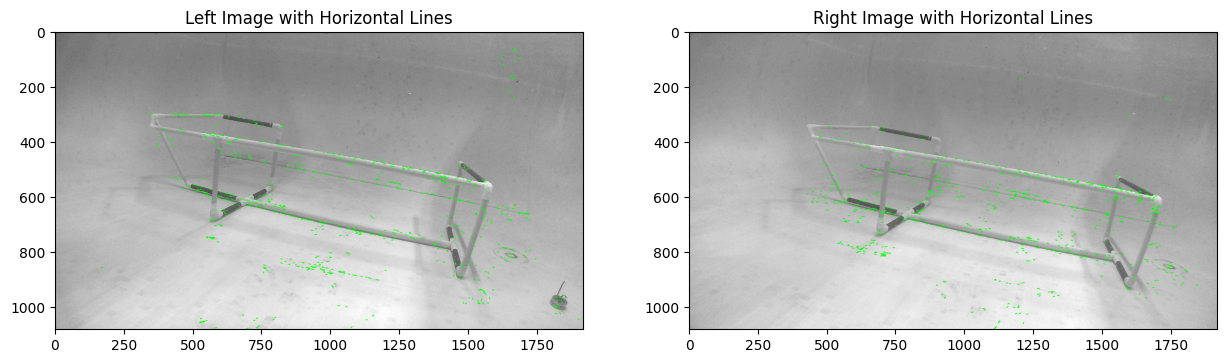

Disparities [px]: [np.float64(423.0), np.float64(423.0)]


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_disparities_on_lines(img_left, img_right, points_left, 
                                 canny_thresh=(10,150),
                                 hough_params=(1, np.pi/180, 10, 50, 5),
                                 horiz_tol=90):
    """
    Compute disparities based on horizontal lines detected via Hough transform.

    Args:
        img_left (np.ndarray): Left grayscale image (uint8).
        img_right (np.ndarray): Right grayscale image (uint8).
        points_left (list of tuples): List of (x, y) coordinates in img_left.
        canny_thresh (tuple): Canny edge detection thresholds (low, high).
        hough_params (tuple): HoughLinesP parameters (rho, theta, threshold, minLineLength, maxLineGap).
        horiz_tol (int): Maximum vertical deviation (pixels) for a line to be considered horizontal.

    Returns:
        list: List of disparities (float) in pixels, or None if no match is found.
    """
    # 1) Edge detection and line finding
    edges_left = cv2.Canny(img_left, *canny_thresh)
    edges_right = cv2.Canny(img_right, *canny_thresh)
    lines_left = cv2.HoughLinesP(edges_left, *hough_params)
    lines_right = cv2.HoughLinesP(edges_right, *hough_params)

    # Filter near-horizontal lines
    def filter_horizontal_lines(lines, tolerance):
        horizontal_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(y2 - y1) <= tolerance:
                    horizontal_lines.append((x1, y1, x2, y2))
        return horizontal_lines

    horizontal_lines_left = filter_horizontal_lines(lines_left, horiz_tol)
    horizontal_lines_right = filter_horizontal_lines(lines_right, horiz_tol)

    # Visualization setup
    def plot_lines(image, lines, color=(0, 255, 0)):
        img_copy = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
        if lines is not None:
            for x1, y1, x2, y2 in lines:
                cv2.line(img_copy, (x1, y1), (x2, y2), color, 2)
        return img_copy

    img_left_lines = plot_lines(img_left, horizontal_lines_left)
    img_right_lines = plot_lines(img_right, horizontal_lines_right)

    # Plotting the images with lines
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cv2.cvtColor(img_left_lines, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Left Image with Horizontal Lines')
    axes[1].imshow(cv2.cvtColor(img_right_lines, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Right Image with Horizontal Lines')
    plt.show()

    disparities = []
    for xP, yP in points_left:
        # Find the line in the left image that contains yP within tolerance
        candidate_lines_left = [l for l in horizontal_lines_left if min(l[1], l[3]) - horiz_tol <= yP <= max(l[1], l[3]) + horiz_tol]
        if not candidate_lines_left:
            disparities.append(None); continue

        # Choose the closest line in x
        line_left = min(candidate_lines_left, key=lambda l: abs((l[0] + l[2]) / 2 - xP))
        xL_line = (line_left[0] + line_left[2]) / 2

        # Match in the right image for the closest y
        yLm = (line_left[1] + line_left[3]) / 2
        if not horizontal_lines_right:
            disparities.append(None); continue

        line_right = min(horizontal_lines_right, key=lambda l: abs((l[1] + l[3]) / 2 - yLm))
        xR_line = (line_right[0] + line_right[2]) / 2

        disparities.append(xL_line - xR_line)

    return disparities

# --- Example Usage ---
# Load images (replace with your actual image loading code)
imgL = cv2.imread('photos/left/test/20250502_193303.jpg', 0)
imgR = cv2.imread('photos/right/test/20250502_193303.jpg', 0)

# Ensure images are loaded correctly
if imgL is None or imgR is None:
    print("Error: Could not load images.")
else:
    # Define two manual points on imgL
    points = [(150, 200), (300, 200)]
    
    # Compute disparities
    disparities = compute_disparities_on_lines(imgL, imgR, points)
    print("Disparities [px]:", disparities)

In [15]:
if 'img_left_rect' in locals() and 'img_right_rect' in locals():
  cv2.imwrite('img_left_rectified.jpg', img_left_rect)
  cv2.imwrite('img_right_rectified.jpg', img_right_rect)
  print("Images saved as 'img_left_rectified.jpg' and 'img_right_rectified.jpg'.")
else:
  print("Rectified images are not available to save.")

Images saved as 'img_left_rectified.jpg' and 'img_right_rectified.jpg'.
